**Imports**

In [ ]:
#!pip install python-dotenv
#!pip install wandb
#!pip install tf-models-official==2.10
#!pip install numpy
#!pip install nibabel
#!pip install matplotlib
#!pip install scikit-image
#!pip install scikit-learn
#!pip install keras
#!pip install tensorflow==2.10
#!pip install opencv-python

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.util import montage 
from skimage.transform import rotate
import keras
import random
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import cv2
import os
from dotenv import load_dotenv
import wandb
from wandb.keras import WandbCallback
load_dotenv()

**Unpack data** 

*NB: Size is 13.5 GB, code is commented out to prevent accidental unpacking*

In [ ]:
# Data can be downloaded here: https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1
# Make sure the file is in the same folder as this project

#import tarfile
#file = tarfile.open('./BraTS2021_Training_Data.tar')

#file.extractall(os.getenv('TRAIN-PATH'))
#file.close()

**Metrics**

In [ ]:
# Borrowed from: https://www.kaggle.com/code/malik12345/brain-tumor-detection-using-cnn-model

axis = (0,1,2,3)

def dice_coef(y_true, y_pred, epsilon=0.00001):
    dice_numerator = 2. * K.sum(y_true * y_pred, axis=axis) + epsilon
    dice_denominator = K.sum(y_true*y_true, axis=axis) + K.sum(y_pred*y_pred, axis=axis) + epsilon
    return K.mean((dice_numerator)/(dice_denominator))

def dice_coef_healthy(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,0] * y_pred[0,:,:,:,0]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,0])) + K.sum(K.square(y_pred[0,:,:,:,0])) + epsilon)

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,1] * y_pred[0,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,1])) + K.sum(K.square(y_pred[0,:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,2] * y_pred[0,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,2])) + K.sum(K.square(y_pred[0,:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[0,:,:,:,3] * y_pred[0,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[0,:,:,:,3])) + K.sum(K.square(y_pred[0,:,:,:,3])) + epsilon)

 
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=axis)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=axis)
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=axis)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=axis)
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)), axis=axis)
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)), axis=axis)
    return true_negatives / (possible_negatives + K.epsilon())

**Data constants**

In [ ]:
IMG_SIZE=120 # Originally 240x240, we reduce this to reduce memory usage
SLICES=128 # Originally 155, reduced for same reason. Must be a power of 2 (or at least divisible by 2, 3 times)
SLICES_START=13 # We skip the first (and the last) few slices as they should contain less information
BATCH_SIZE=1
CHANNELS=4
DATA_AUG=False # Enables data augmentation
DATA_AUG_FACTOR=0 # If we have n data elements, we will have DATA_AUG_FACTOR*n data elements to train on

TRAIN_DATASET_PATH = os.getenv('TRAIN-PATH')

**Data generation**

In [ ]:
def RandomBrightness(X, y):
  X = tf.image.stateless_random_brightness(X, 0.2, seed=(1,2)).numpy()
  y = tf.image.stateless_random_brightness(y, 0.2, seed=(1,2)).numpy()
  return X, y

def RandomRotate(X, y):
    r = random.randint(0,3)
    # rotate by 90 degrees times random r
    X = np.rot90(X, k=r)
    y = np.rot90(y, k=r)
    return X, y 
    
def AugmentData(X, y):
  X, y = RandomRotate(X, y)
  X, y = RandomBrightness(X, y)
  return X, y

# Some of the data generation was borrowed from: https://www.kaggle.com/code/malik12345/brain-tumor-detection-using-cnn-model
  
data_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

data_ids = pathListIntoIds(data_directories); 

    
train_and_test_ids, val_ids = train_test_split(data_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_and_test_ids,test_size=0.2)


keras = tf.compat.v1.keras
Sequence = keras.utils.Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = BATCH_SIZE, n_channels = CHANNELS, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        Batch_ids = [self.list_IDs[k] for k in indexes]

        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        # Initialization
        X = np.zeros((self.batch_size*SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*SLICES, IMG_SIZE, IMG_SIZE))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz');
            flair = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz');
            ce = nib.load(data_path).get_fdata()   
            
            data_path = os.path.join(case_path, f'{i}_t1.nii.gz');
            t1 = nib.load(data_path).get_fdata()       

            data_path = os.path.join(case_path, f'{i}_t2.nii.gz');
            t2 = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii.gz');
            seg = nib.load(data_path).get_fdata()
        
            # resize images to specified dimensions and insert into X and y
            for j in range(SLICES):
                X[j+(SLICES*c),:,:,0] = cv2.resize(flair[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))
                X[j+(SLICES*c),:,:,1] = cv2.resize(ce[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))
                X[j+(SLICES*c),:,:,2] = cv2.resize(t1[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))
                X[j+(SLICES*c),:,:,3] = cv2.resize(t2[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))                
                
                y[j +SLICES*c,:,:] = cv2.resize(seg[:,:,j+SLICES_START], (IMG_SIZE, IMG_SIZE))

        if DATA_AUG: X, y = AugmentData(X, y)

        X = X.reshape(1,SLICES,IMG_SIZE,IMG_SIZE, CHANNELS)
        y = y.reshape(1,SLICES,IMG_SIZE,IMG_SIZE)
        # Generate masks
        y = tf.one_hot(y, 4);

        # Avoid dividing by zero - return early
        if np.max(X) == 0.0:
          return np.zeros(X.shape), y

        return X/np.max(X), y
        
training_generator = DataGenerator(train_ids*DATA_AUG_FACTOR) if DATA_AUG else DataGenerator(train_ids) 
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

**Baseline model**

In [ ]:
def unet_3d_conv(layer, filters):
    layer = Conv3D(filters, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = Activation('relu')(layer)
    return layer


def unet_3d(input_img):
    c1 = unet_3d_conv(input_img, 8)
    c2 = unet_3d_conv(c1, 16)
    
    c3 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(c2)
    

    c4 = unet_3d_conv(c3, 16)
    c5 = unet_3d_conv(c4, 32)
    c6 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(c5)

    c7 = unet_3d_conv(c6, 32)
    c8 = unet_3d_conv(c7, 64)
    c9 = MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2))(c8)

    c10 = unet_3d_conv(c9, 64)
    c11 = unet_3d_conv(c10, 128)
    c12 = UpSampling3D(2)(c11)

    c13 = concatenate([c8, c12])
    c14 = unet_3d_conv(c13, 64)
    c15 = unet_3d_conv(c14, 64)
    c16 = UpSampling3D(2)(c15)

    c17 = concatenate([c5, c16])
    c18 = unet_3d_conv(c17, 32)
    c19 = unet_3d_conv(c18, 32)
    c20 = UpSampling3D(2)(c19)

    c21 = concatenate([c2, c20])
    c22 = unet_3d_conv(c21, 16)
    c23 = unet_3d_conv(c22, 16)
    c24 = Conv3D(4, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(c23)
    c25 = Activation('softmax')(c24)


    model = Model(inputs=input_img, outputs=c25)
    return model 


input_layer = Input((SLICES, IMG_SIZE, IMG_SIZE, CHANNELS))
model = unet_3d(input_layer) 

**Train and test (baseline) model**

In [ ]:
LR = 0.01
EPOCHS = 20
SAVE_MODEL = False # Whether to save the model after training

wandb.init(project="BraTS2021", entity="vj-dl")
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
  "img_size": IMG_SIZE, 
  "slices": SLICES
}

model.compile(optimizer=keras.optimizers.SGD(learning_rate=LR), loss="categorical_crossentropy", metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing, dice_coef_healthy])
model.summary()
model.fit(training_generator, epochs=EPOCHS, validation_data=valid_generator, callbacks=[])
if SAVE_MODEL:
  model.save("baseline_model.h5")


**Reconstruct model and test it**

In [ ]:
reconstructed_model = keras.models.load_model("baseline_model.h5", custom_objects={"dice_coef":dice_coef, 
                                                                                "precision":precision, 
                                                                                "sensitivity":sensitivity, 
                                                                                "specificity":specificity,
                                                                                "dice_coef_necrotic":dice_coef_necrotic, 
                                                                                "dice_coef_edema":dice_coef_edema, 
                                                                                "dice_coef_enhancing":dice_coef_enhancing,
                                                                                "dice_coef_healthy": dice_coef_healthy})
reconstructed_model.evaluate(test_generator)

**Evaluate on test data**

In [ ]:
model.evaluate(test_generator)

**Callbacks for improved model**

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_dice_coef', min_delta=0,
                               patience=5, verbose=1, mode='max'),
            keras.callbacks.ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1, mode='max')
    ]

**Improved model definition**

In [ ]:
def unet_3d_conv(layer, filters):
    layer = Conv3D(filters, kernel_size=(3,3,3), strides=(1,1,1), padding='same')(layer)
    layer = BatchNormalization()(layer)
    layer = Activation('relu')(layer)
    return layer


def unet_3d(input_img):
    c1 = unet_3d_conv(input_img, 8)
    c2 = unet_3d_conv(c1, 16)
    
    c3 = Conv3D(16, kernel_size=(3,3,3), strides=(2,2,2), padding='same')(c2) # Use convolution instead of max pool
    

    c4 = unet_3d_conv(c3, 16)
    c5 = unet_3d_conv(c4, 32)
    c6 = Conv3D(32, kernel_size=(3,3,3), strides=(2,2,2), padding='same')(c5)

    c7 = unet_3d_conv(c6, 32)
    c8 = unet_3d_conv(c7, 64)
    c9 = Conv3D(64, kernel_size=(3,3,3), strides=(2,2,2), padding='same')(c8)

    c10 = unet_3d_conv(c9, 64)
    c11 = unet_3d_conv(c10, 128)
    c12 = Conv3DTranspose(128, kernel_size=(2,2,2), strides=(2,2,2), padding='same')(c11) # Use Transpose instead of UpSampling, kernel size should be divisble by stride

    c13 = concatenate([c8, c12])
    c14 = unet_3d_conv(c13, 64)
    c15 = unet_3d_conv(c14, 64)
    c16 = Conv3DTranspose(64, kernel_size=(2,2,2), strides=(2,2,2), padding='same')(c15)

    c17 = concatenate([c5, c16])
    c18 = unet_3d_conv(c17, 32)
    c19 = unet_3d_conv(c18, 32)
    c20 = Conv3DTranspose(32, kernel_size=(2,2,2), strides=(2,2,2), padding='same')(c19)

    c21 = concatenate([c2, c20])
    c22 = unet_3d_conv(c21, 16)
    c23 = unet_3d_conv(c22, 16)
    c24 = Conv3D(4, kernel_size=(1,1,1), strides=(1,1,1), padding='same')(c23)
    c25 = Activation('softmax')(c24)


    model = Model(inputs=input_img, outputs=c25)
    return model 


input_layer = Input((SLICES, IMG_SIZE, IMG_SIZE, CHANNELS))
improved_model = unet_3d(input_layer) 
improved_model.summary()

**Train and test improved model**

In [ ]:
LR = 0.001
EPOCHS = 20
SAVE_MODEL = False # Whether to save the model after training

wandb.init(project="BraTS2021", entity="vj-dl")
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
  "img_size": IMG_SIZE, 
  "slices": SLICES
}

improved_model.compile(optimizer=keras.optimizers.Nadam(learning_rate=LR), loss="categorical_crossentropy", metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing, dice_coef_healthy])
improved_model.fit(training_generator, epochs=EPOCHS, validation_data=valid_generator, callbacks=[callbacks, WandbCallback()])
if SAVE_MODEL: improved_model.save("dataaug_improved_model.h5") if DATA_AUG else improved_model.save("improved_model.h5")


**Evaluate improved model**

In [ ]:
improved_model.evaluate(test_generator)

**Reconstruct saved model and evaluate it**

In [ ]:
reconstructed_model = keras.models.load_model("improved_model.h5", custom_objects={"dice_coef":dice_coef, 
                                                                                "precision":precision, 
                                                                                "sensitivity":sensitivity, 
                                                                                "specificity":specificity,
                                                                                "dice_coef_necrotic":dice_coef_necrotic, 
                                                                                "dice_coef_edema":dice_coef_edema, 
                                                                                "dice_coef_enhancing":dice_coef_enhancing,
                                                                                "dice_coef_healthy": dice_coef_healthy})
reconstructed_model.evaluate(test_generator)

**Plotting**

1/1 [==============================] - 0s 26ms/step


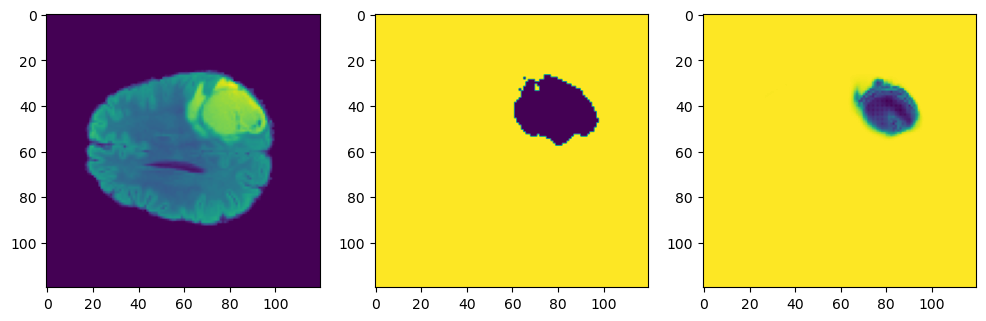

In [133]:
# Get first element (i.e. a 3D scan) from test generator
img1 = test_generator[68]


# get the data of the scan, first 0 is X from (X, y), next 0 is from the batch (which only has one element)
data = img1[0][0]

# Get the ground truth of the training image above (i.e. y from (X, y))
segmentation = img1[1][0]


prediction = reconstructed_model.predict(img1[0]) # predict segmentation
prediction = prediction[0] # get first in batch (i.e. the only element)

# [70,:,:,0] is slice 70. 0 is the FLAIR channel for the training data.
# [70,:,:,0] is slice 70. 0 is the healthy tissue for the masks.

_, axs = plt.subplots(1, 3, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip([data[80,:,:,0], segmentation[80, :, :, 0], prediction[80, :, :, 0]], axs):
    ax.imshow(img)
plt.show()